In [1]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment by creating mini batches etc.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score
from torch.autograd import Variable 

In [3]:
#read the data from the files
#read the data 
#algorithm to read all the files 

'''
for folder in this folder:
    read xelasensor1.csv
    read sliplabel.csv
    concat it in a single dataframe along axis = 0

print the dataframe
'''

directory = '/Users/elijahnelson/Desktop/SIWES/IML/Tactile_IML/train2dof'
directory2 = '/Users/elijahnelson/Desktop/SIWES/IML/Tactile_IML/'

def read_file(detect_or_pred, n = None):

    #store all directories in a list
    list_xela_allfiles = []
    list_sliplabel_allfiles = []

    for root, subdirectories, files in os.walk(directory):
        for sdirectory in subdirectories:

            #subdirectory with absolute path
            subdirectory = '{}/{}'.format(root, sdirectory)

            #read specific files in the subdirectory
            for file in os.listdir(subdirectory):
            
                if file.endswith("sensor1.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    
                    if detect_or_pred ==0:
                        list_xela_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None:
                        list_xela_allfiles.append(df[:-n])

                if file.endswith("label.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    if detect_or_pred ==0:
                        list_sliplabel_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None: 
                        list_sliplabel_allfiles.append(df[n:])

    return list_xela_allfiles, list_sliplabel_allfiles

    #np.newaxis; np.zeros (3,4,4) -> 
                    



In [4]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
n = 5
list_xela_allfiles, list_sliplabel_allfiles = read_file(0)

#for slip prediction, comment the line above and uncomment the line below
#list_xela_allfiles, list_sliplabel_allfiles = read_file(1, n)

pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']

#reshape the target array into (rows, 1)
#tac_label 
pd_sliplabel_allfiles = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)
tac_label = pd_sliplabel_allfiles

sc = StandardScaler()

data = pd_xela_allfiles.to_numpy()
data = sc.fit_transform(data)
labels = pd_sliplabel_allfiles
(data.shape, labels.shape)

((229651, 48), (229651, 1))

<AxesSubplot:>

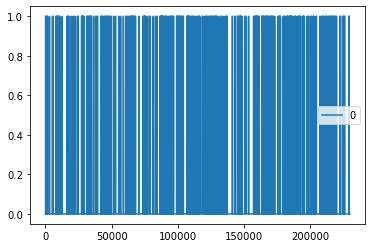

In [5]:
df = pd.DataFrame(labels)
df.plot()

# CONV LSTM 

# Arrange the data to form images


In [6]:
#arrange the 48 row data to form 3, 4, 4

#arrange the columns by x, y, z
col_x = []
col_y = []
col_z = []

pd_columns = pd_xela_allfiles.columns
for col in pd_columns:
    if col.endswith('x'):
        col_x.append(col)
    
    elif col.endswith('y'):
        col_y.append(col)
    
    elif col.endswith('z'):
        col_z.append(col)

#arrange the table using the arranged columns
pd_xela_allfiles_x = pd_xela_allfiles[col_x]
pd_xela_allfiles_y = pd_xela_allfiles[col_y]
pd_xela_allfiles_z = pd_xela_allfiles[col_z]


#scale the data in the arranged columns
#scale the data of the features

sc = MinMaxScaler() #standard scaler
sc.fit(pd_xela_allfiles_x)
pd_xela_allfiles_x = sc.transform(pd_xela_allfiles_x)

sc.fit(pd_xela_allfiles_y)
pd_xela_allfiles_y = sc.transform(pd_xela_allfiles_y)

sc.fit(pd_xela_allfiles_z)
pd_xela_allfiles_z = sc.transform(pd_xela_allfiles_z)



#reshape the arranged data per row to (4,4) AND rotate 90 degree anti-clockwise and append to a list
pd_x = []
pd_y = []
pd_z = []

for row in range(len(pd_xela_allfiles_x)):
    pd_x.append(np.rot90(pd_xela_allfiles_x[row].reshape(4,4)))
    pd_y.append(np.rot90(pd_xela_allfiles_y[row].reshape(4,4)))
    pd_z.append(np.rot90(pd_xela_allfiles_z[row].reshape(4,4)))

#add all the x, y, z in a single list
pd_main = [pd_x, pd_y, pd_z]

#arrange pd_main in a 3, 4, 4 array where its 3(4, 4) of x, y, z values
pd_image = np.zeros( (pd_xela_allfiles.shape[0], 3, 4, 4))

#per row, get (4,4) of x, y, z and assign it to pd_image to form the image
for row in range(pd_xela_allfiles.shape[0]):
    x_4_4 = pd_main[0][row]
    y_4_4 = pd_main[1][row]
    z_4_4 = pd_main[2][row]

    pd_image[row][0] = x_4_4
    pd_image[row][1] = y_4_4
    pd_image[row][2] = z_4_4


# Upscale the Image

In [7]:
# Upscale the image, Train, Get the shape, Form my dense layer

#Upscale the (4,4) part of the 3, 4, 4 image to 16, 16, 16,
import cv2

up_size = 64
n_images = len(pd_x)
tac_image = np.zeros((n_images, 3, up_size, up_size), np.float32) 
for row in range(n_images):

    #resize image to 3, up_size, up_size
    for channel in range(3):
        image_per_channel = pd_image[row][channel]
        tac_image[row][channel] = cv2.resize(image_per_channel.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)


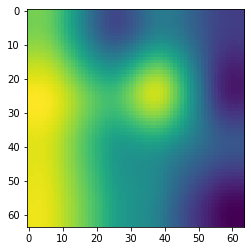

In [8]:
# Show scaled image
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
''' X = tac_image[199000][0]
Y = tac_image[199000][1]
Z = tac_image[199000][2]

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0,
       cstride = 1, rstride = 1)
plt.show() '''

# see also
plt.imshow(tac_image[0][1])
plt.show()


In [ ]:
#convert to tensor values
tac_image = torch.from_numpy(tac_image.astype(np.float32))
tac_label = torch.from_numpy(tac_label.astype(np.float32))

# Design the ConvLSTM


In [ ]:
#Train and Validation split
data_train, data_test, labels_train, labels_test = train_test_split(tac_image, tac_label, test_size = 0.25, shuffle = False)

In [ ]:
class seq_dataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len
    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)
    def __getitem__(self, index):
        return self.X[index:index+self.seq_len], self.y[index+self.seq_len-1]

In [ ]:
batch_size = 1024

train_dataset = seq_dataset(data_train, labels_train, 10)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)

val_dataset = seq_dataset(data_test, labels_test, 10)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias, device):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.device = device
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim, out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size, padding=self.padding, bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o) 
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device).to(self.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device).to(self.device))

In [ ]:
class Model(nn.Module):
    def __init__(self, device):
        super(Model, self).__init__()
        self.device = device
        self.convlstm1 = ConvLSTMCell(input_dim=3, hidden_dim=3, kernel_size=(3, 3), bias=True, device=self.device).to(self.device)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1).to(self.device)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1).to(self.device)
        self.maxpool1 = nn.MaxPool2d(4, stride=4)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        self.relu1 = nn.ReLU().to(self.device)
        self.relu2 = nn.ReLU().to(self.device)
        self.relu3 = nn.ReLU().to(self.device)
        self.dense1 = nn.Linear(256, 64).to(self.device)
        self.dense2 = nn.Linear(64, 32).to(self.device)
        self.dense3 = nn.Linear(32, 1).to(self.device)
        self.relu4 = nn.ReLU().to(self.device)
        self.relu5 = nn.ReLU().to(self.device)
        self.flatten = nn.Flatten().to(self.device)
        self.sigmoid = nn.Sigmoid().to(self.device)
        # self.optimizer = optim.Adam(Model.parameters(), lr=0.0001)
        # self.criterion = nn.BCELoss()

    def forward(self,X):
        hidden, cell = self.convlstm1.init_hidden(batch_size=batch_size, image_size=(64, 64))
        for t in range(10):
            hidden, cell = self.convlstm1(input_tensor=X[:,t,:,:,:], cur_state=[hidden, cell])
        x = self.maxpool1(self.relu1(self.conv1(hidden).float()))
        x = self.maxpool2(self.relu2(self.conv2(x).float()))
        x = self.maxpool3(self.relu3(self.conv3(x).float()))
        x = self.flatten(x)
        x = self.relu4(self.dense1(x).float())
        x = self.relu5(self.dense2(x).float())
        out = self.sigmoid(self.dense3(x).float())
        return out

In [ ]:
device = torch.device("cpu")
model = Model(device)
model.load_state_dict(torch.load("CONV_LSTM_working.pth"))

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
weight = torch.Tensor([5])
criterion = nn.BCELoss(weight=weight)

num_epochs = 100

loss_per_batch = []
loss_per_epoch= []
loss_per_epoch_val = []
t_loss = []
v_loss = []
t_acc = []
v_acc = []


for epoch in range(1, num_epochs+1):
    train_loss = []   
    train_acc = []  
    t_correct = 0                                            
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1): 
        print(f'Batch: {batch_num}')                              
        optim.zero_grad()  
        output = model(input) 
        loss = criterion(output.flatten(), target.flatten()) 
        #loss_per_batch.append(loss.item())  
        loss.backward()                                            
        optim.step()                                             
        train_loss.append(loss.item())                             
    #train_loss /= len(train_loader.dataset) 
    #loss_per_epoch.append(train_loss)

    #accuracy
        t_correct += output.round().eq(target).sum().item()
        train_acc.append(t_correct/target.shape[0])

    val_loss = []  
    val_acc = []  
    v_correct = 0                                            
    model.eval()                                                   
    with torch.no_grad():                                          
        for batch_num, (input, target) in enumerate(val_loader, 1):   
            print(f'Validation Batch: {batch_num}')          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss.append(loss.item())   

            v_correct += output.round().eq(target).sum().item()
            val_acc.append(v_correct/target.shape[0])                           
    #val_loss /= len(val_loader.dataset)  
    #loss_per_epoch_val.append(val_loss)  

    t_loss.append(np.mean(train_loss))
    v_loss.append(np.mean(val_loss))
    t_acc.append(np.mean(train_acc))     
    v_acc.append(np.mean(val_acc))                        

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f} Training Acc:{:.2f} Validation Acc:{:.2f}\n"\
          .format(epoch, (np.mean(train_loss)), np.mean(val_loss), (np.mean(train_acc)), np.mean(val_acc)))        


In [ ]:
plt.plot(t_loss)

In [ ]:
plt.plot(v_loss)

In [ ]:
def lstm_metrics(xela_test, sliplabel_test):
    #predict using the holdout set (DONE)
    predicted_cls = xela_test

    #Plot the loss values against number of epochs (DONE)
    #validation test (DONE)

    #Print the accuracy
    x = 0
    for i in range(predicted_cls.shape[0]):
        if predicted_cls[i, 0].item() == sliplabel_test[i, 0]:
            x += 1

    accuracy = x/ float(sliplabel_test.shape[0])
    # print(f'Accuracy for slip detection is {accuracy}')

    #Print the fscore
    fscore = f1_score(sliplabel_test, predicted_cls, average='macro')
    # print (f'Fscore for slip detection is {fscore}')

    #print the Precision
    precision = precision_score(sliplabel_test, predicted_cls, average='macro')
    # print(f'Precision for slip detection is {precision}')

    #print the Recall
    recall = recall_score(sliplabel_test, predicted_cls, average='macro')
    # print(f'Recall for slip detection is {recall}')

    return accuracy, fscore, precision, recall

In [ ]:
# # model = Model(device)
model.load_state_dict(torch.load("CONV_LSTM_working.pth"))

In [ ]:
Y_PRED = []
Y_VAL = []
ACC = []
FSCORE = []
RECALL = []
PRECISION = []
x=0
for (i,t) in val_loader:
    x+=1
    y_predict = model.forward(i)
    y_predict = y_predict.round()
    y_predict = y_predict.data.numpy()
    # y_predict = y_predict.flatten()
    y_valid = t#.flatten()
    accuracy, fscore, precision, recall = lstm_metrics(y_predict, y_valid)
    ACC.append(accuracy)
    FSCORE.append(fscore)
    PRECISION.append(precision)
    RECALL.append(recall)
    print(f'{x} / {len(val_loader)}')

# y_predict = [model.forward(i) for i,t in val_loader]
# y_valid = [t for i,t in val_loader]
# y_predict = torch.Tensor(y_predict)
# y_valid = torch.Tensor(y_valid)
# print(y_predict.shape)
# y_predict = y_predict.flatten()
# y_valid = y_valid.flatten()
# y_predict = y_predict.round()
# y_predict = y_predict.data.numpy()
# y_valid = y_valid
# lstm_metrics(y_predict, y_valid)

In [ ]:
accuracy = np.mean(ACC)
fscore = np.mean(FSCORE)
precision = np.mean(PRECISION)
recall = np.mean(RECALL)

print(f'Accuracy: {accuracy}, Fscore: {fscore}, Recall: {recall}, Precision: {precision}')